In [89]:
import random
import matplotlib.pyplot as plt

In [100]:
class Job():
    '''
    This class aims to represent jobs that are to be assigned to nodes
    The basic characteristics of nodes jobs are CPU request,
    memory request and file size to send to the master. These numbers represent the max,
    resoruces the job will use from the node
    '''
    
    def __init__(self, job_id, cpu_request, memory_request, file_size):
        self.job_id = job_id
        self.cpu_request = cpu_request
        self.memory_request = memory_request
        self.file_size = file_size
    
    def set_cpu_request(self, cpu_request):
        ''' This method sets the CPU request of the job'''
        self.cpu_request = cpu_request
        
    def set_memory_request(self, memory_request):
        ''' This method sets the memory request of the job'''
        self.memory_request = memory_request
        
    def set_file_size(self, file_size):
        ''' 
        This method sets the file size of the job
        For now the file_size is represented as standard integer units.
        More info in bw method of class Node()
        '''
        self.file_size = file_size
    
    def get_job_id(self):
        '''This method returns the id of the job'''
        return self.job_id
        
    def get_cpu_request(self):
        ''' This method returns CPU request of the job'''
        return self.cpu_request
    
    def get_memory_request(self):
        ''' This method returns the memory request'''
        return self.memory_request
    
    def get_file_size(self):
        ''' This method returns the file size'''
        return self.file_size

In [101]:
class Node():
    '''
    This class aims to represente computing nodes of a cluster
    The basic properties of the nodes are CPU, memory and bandwidth (BW)
    BW is considered the capacity of data transmision between the node and an hypothetic node where data is sent
    '''
    
    def __init__(self, node_id, cpu_capacity, memory_capacity, bw):
        self.node_id = node_id
        self.cpu_capacity = cpu_capacity
        self.memory_capacity = memory_capacity
        self.bw = bw
        self.cpu_available = cpu_capacity
        self.memory_available = memory_capacity
        self.cpu_used = 0
        self.memory_used = 0
        self.jobs = []
        
    def set_cpu_capacity(self, cpu_capacity):
        '''
        This method sets the total CPU capacity of the node
        The CPU units are in milicores: 1000m = 1core
        Whenever this method is call the available CPU gets to 100%. The jobs are released
        '''
        if cpu_capacity - self.cpu_used < 0:
            print('CPU resources cannot be reduced')
        else:
            self.cpu_capacity = cpu_capacity
            self.update_available_resources()
    
    def set_memory_capacity(self, memory_capacity):
        '''
        This method sets the total memory capacity of the node
        The memory units are MB: 1GB = 1000MB = 1000000KB
        Whenever this method is call the available CPU gets to 100%. The jobs are released
        '''
        if memory_capacity - self.memory_used < 0:
            print('Memory resources cannot be reduced')
        else:
            self.memory_capacity = memory_capacity
            self.update_available_resources()
        
    def set_bw(self, bw):
        '''
        This method sets the total bw capacity of the link b
        For now the bandwidth is represented as the number of file_size units
        the node is capable to consume in one time step
        '''
        self.bw = bw
        
    def get_node_id(self):
        return self.node_id
        
    def get_cpu_capacity(self):
        '''This method returns the cpu capacity of the node'''
        return self.cpu_capacity
    
    def get_memory_capacity(self):
        '''This method returns the memory capcity of the node'''
        return self.memory_capacity
    
    def get_bw(self):
        '''This method returns the bw'''
        return self.bw
    
    def get_cpu_used(self):
        '''This method returns the used CPU'''
        return self.cpu_used
        
    def get_memory_used(self):
        '''This method returns the used memory'''
        return self.memory_used
    
    def get_cpu_available(self):
        '''This method returns the available CPU'''
        return self.cpu_available
    
    def get_memory_available(self):
        '''This method returns the available memory'''
        return self.memory_available
    
    def get_jobs(self):
        '''
        This method returns a list of dicts containing the jobs allocated in the nodes
        and their remaining time of execution in the node
        '''
        return self.jobs
    
    def update_available_resources(self):
        '''This method updates the available resources'''
        self.cpu_available = self.cpu_capacity - self.cpu_used
        self.memory_available = self.memory_capacity - self.memory_used
        
    def consume_resources(self, job):
        '''
        This method decreases the available cpu and memory
        based on the appended job CPU and memory requests.
        '''
        self.cpu_used += job.get_cpu_request()
        self.memory_used += job.get_memory_request()
        self.update_available_resources()
        
    def release_resources(self, job):
        ''' 
        This method calculates and returns the file transfer time
        given the file size and the bw of the node
        '''
        self.cpu_used -= job.get_cpu_request()
        self.memory_used -= job.get_memory_request()
        self.update_available_resources()
        
    def transfer_duration(self, job):
        ''' 
        This method calculates and returns the file transfer time
        given the file size and the bw of the node
        '''
        total_transfer_duration = job.get_file_size() / self.bw
        return total_transfer_duration
    
    def check_resources(self, job):
        '''
        This method returns a False if the node has not enough available resources to allocate the job.
        Returns True otherwise
        '''
        cpu_resources = job.get_cpu_request() > self.get_cpu_available()
        memory_resources = job.get_memory_request() > self.get_memory_available()
        if cpu_resources or memory_resources:
            return False
        else:
            return True
        
    def decrease_job_time(self):
        '''
        This method decreases the duration of all the jobs allocated in that node by one
        If the remaining time is 0, the job is terminated from the node
        '''
        jobs_copy = self.jobs[:]
        for job in jobs_copy:
            if job['time'] == 1:
                self.terminate_job(job)
        for job in self.jobs:
            job['time'] -= 1      
            
    def append_job(self, job):
        '''
        This method appends the job passed as an argument to the node.
        The available resources in the node are updated.
        The transfer time of the file attached to job is calculated and returned
        '''
        if self.check_resources(job):
            total_transfer_duration = self.transfer_duration(job)
            self.jobs.append({
                'job': job,
                'time': total_transfer_duration
            })
            self.consume_resources(job)     
        else:
            print('The job cannot be allocated. There is not enough available resoruces in the node.')
    
    def terminate_job(self, job):
        '''
        This method releases the specified job running in the node
        The available resources in the node are updated
        '''
        self.jobs.remove(job)
        self.release_resources(job['job'])
        

## Functions


In [102]:
def number_of_jobs(jobs_list, n_min, n_max):
    '''
    This function generates a number between n_min and n_max
    for the number of jobs to be allocated at each time-step.
    When the number of remaining jobs in the list is less than the generated number,
    the number of jobs is the remaining jobs to be allocated
    '''
    n_jobs_iteration = random.randint(n_min, n_max)
    if n_jobs_iteration > len(jobs_list):
        n_jobs_iteration = len(jobs_list)
    return n_jobs_iteration

In [108]:
def display_node_status(nodes):
    '''
    This function displays the status of each node at each time step.
    CPU usage, memopry usage and allocated jobs.
    Requires as an input a list of nodes
    '''
    status = '\n Iteration ' + str(iteration)
    for node in nodes:
        status += '\n \t Status of Node ' + str(node.get_node_id()) + ':'
        status += '\n \t \t Bw: ' + str(node.get_bw())
        status += '\n \t \t CPU: ' + str(node.get_cpu_used()) + '/' + str(node.get_cpu_capacity()) + ' c'
        status += '\n \t \t Memory: ' + str(node.get_memory_used()) + '/' + str(node.get_memory_capacity()) + ' MB'
        status += '\n \t \t Jobs allocated:'
        for job in node.get_jobs():
            status += '\n \n \t \t \t Job: ' + str(job['job'].get_job_id())
            status += '\n \t \t \t CPU req: ' + str(job['job'].get_cpu_request()) + ' c'
            status += '\n \t \t \t Memory req: ' + str(job['job'].get_memory_request()) + ' MB'
            status += '\n \t \t \t Time remaining: ' + str(job['time']) + 's'
        print(status)
        status = ''  

## First experiment

In this first experiment the goal is to check that both classes work properly and can interact between them. The main components will be:

1. Two nodes: Each node will have different charactersitics

    * Node's CPU
    * Node's memory
    * Node's BW

2. Two types of jobs: Each type will have different characteristics

    * Jobs CPU
    * Jobs memory
    * jobs file_size
    * jobs will be created and appended in each of the nodes dynamically at different time steps
    * Number of jobs created at each time step
    * jobs that do not have space will wait in a buffer
    * Maximum jobs in the buffer

This process will last for a certain number of timesteps. Data of the deployment will be stored for later visualization and tracking of the performance.

The aim of this first experiment is to achieve a simulation in which at each time step new jobs are added to the node and that jobs are afterwards terminated until the simulation is finished.

### Fix number of jobs

In this approach the number of jobs is fixed and the program finish when all of the jobs have been allocated and terminated from the nodes.

In [111]:
# Number of jobs
n_jobs = 20

# Characteristics job 1
cpu_job_1 = 1
memory_job_1 = 200
file_size_job_1 = 2

# Characteristics job 2
cpu_job_2 = 0.5
memory_job_2 = 500
file_size_job_2 = 4

# Append in lists the requirements of the jobs
cpu_jobs_reqs = [cpu_job_1, cpu_job_2]
memory_jobs_reqs = [memory_job_1, memory_job_2]
file_size_jobs_reqs = [file_size_job_1, file_size_job_2]

# Create a list to store the jobs
jobs_list = []

# We store 1 job in the list in each iteration randomly choosing between the two types of jobs
for i in range(n_jobs):
    job_type = random.randint(0, 1)
    cpu_job = cpu_jobs_reqs[job_type]
    memory_job = memory_jobs_reqs[job_type]
    file_size_job = file_size_jobs_reqs[job_type]
    jobs_list.append(Job(i, cpu_job, memory_job, file_size_job))
    
# Create the two nodes

# Characteristics node 1
cpu_node_1 = 20
memory_node_1 = 10000
bw_node_1 = 1

# Characteristics node 2
cpu_node_2 = 20
memory_node_2 = 10000
bw_node_2 = 2

node_1 = Node(1, cpu_node_1, memory_node_1, bw_node_1)
node_2 = Node(2, cpu_node_2, memory_node_2, bw_node_2)
nodes = [node_1, node_2]

# The program loop:
# In each iteration a stochastic number of jobs will be appended to the nodes until there is no more jobs to append


In [112]:
n_jobs_node_1 = []
n_jobs_node_2 = []
n_new_jobs = [0]
iteration = 0

while jobs_list:      
    display_node_status(nodes)
    for node in nodes:
        node.decrease_job_time()
        
    n_jobs_iteration = number_of_jobs(jobs_list, 2, 4)
    for i in range(n_jobs_iteration):
        node = random.choice(nodes)
        node.append_job(jobs_list.pop())
        
    n_new_jobs.append(n_jobs_iteration)
    n_jobs_node_1.append(len(nodes[0].get_jobs()))
    n_jobs_node_2.append(len(nodes[1].get_jobs()))
    
    iteration += 1


 Iteration 0
 	 Status of Node 1:
 	 	 Bw: 1
 	 	 CPU: 0/20 c
 	 	 Memory: 0/10000 MB
 	 	 Jobs allocated:

 	 Status of Node 2:
 	 	 Bw: 2
 	 	 CPU: 0/20 c
 	 	 Memory: 0/10000 MB
 	 	 Jobs allocated:

 Iteration 1
 	 Status of Node 1:
 	 	 Bw: 1
 	 	 CPU: 1/20 c
 	 	 Memory: 200/10000 MB
 	 	 Jobs allocated:
 
 	 	 	 Job: 19
 	 	 	 CPU req: 1 c
 	 	 	 Memory req: 200 MB
 	 	 	 Time remaining: 2.0s

 	 Status of Node 2:
 	 	 Bw: 2
 	 	 CPU: 1.5/20 c
 	 	 Memory: 700/10000 MB
 	 	 Jobs allocated:
 
 	 	 	 Job: 18
 	 	 	 CPU req: 0.5 c
 	 	 	 Memory req: 500 MB
 	 	 	 Time remaining: 2.0s
 
 	 	 	 Job: 17
 	 	 	 CPU req: 1 c
 	 	 	 Memory req: 200 MB
 	 	 	 Time remaining: 1.0s

 Iteration 2
 	 Status of Node 1:
 	 	 Bw: 1
 	 	 CPU: 3.0/20 c
 	 	 Memory: 1400/10000 MB
 	 	 Jobs allocated:
 
 	 	 	 Job: 19
 	 	 	 CPU req: 1 c
 	 	 	 Memory req: 200 MB
 	 	 	 Time remaining: 1.0s
 
 	 	 	 Job: 16
 	 	 	 CPU req: 0.5 c
 	 	 	 Memory req: 500 MB
 	 	 	 Time remaining: 4.0s
 
 	 	 	 Job: 15

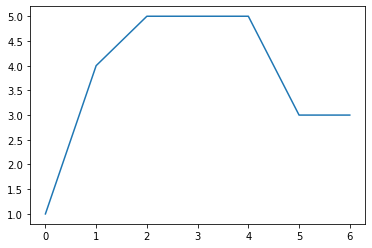

In [113]:
plt.plot(n_jobs_node_1)

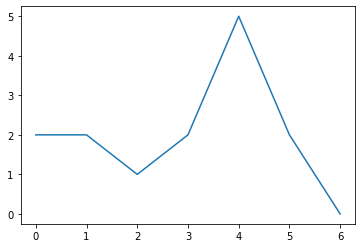

In [114]:
plt.plot(n_jobs_node_2)

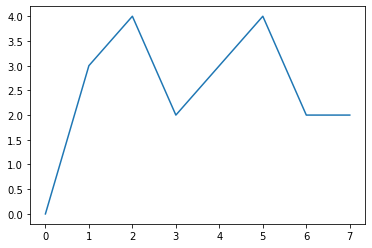

In [115]:
plt.plot(n_new_jobs)